# Introduction





One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. Given the prior knowledge of this topic, investigating the correlations between SAT scores and demographics will be an interesting angle to take in this project. We could correlate SAT scores with factors like race, gender, income, and more.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for this project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

New York City makes its data on high school SAT scores available online, as well as the demographics for each high school. 

Unfortunately, combining both of the data sets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do the full analysis.

The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

   * [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
   * [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
   * [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
   * [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
   * [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
   * [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
   * [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school
   * [High School Directory](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2) - A directory of high schools


# Read in the data

All the data have been placed in the schools folder. The data will be read into the pandas dataframe and then stored in a dictionary.

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
#We are mainly  interested in the sat dataset, so we
#print the first rows of sat_results to make some observations
print(data['sat_results'].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

We can make a few observations based on this output:

* The DBN appears to be a unique ID for each school.
* We can tell from the first few rows of names that we only have data about high schools.
* There's only a single row for each high school, so each DBN is unique in the SAT data.
* We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.

Given these observations, let's explore the other data sets to see if we can gain any insight into how to combine them.

In [3]:
for k in data:
    print(data[k].head(),'\n')

      DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   
2  01M015  P.S. 015 ROBERTO CLEMENTE    20072008       89.4          NaN   
3  01M015  P.S. 015 ROBERTO CLEMENTE    20082009       89.4          NaN   
4  01M015  P.S. 015 ROBERTO CLEMENTE    20092010                    96.5   

   total_enrollment prek   k grade1 grade2    ...     black_num black_per  \
0               281   15  36     40     33    ...            74      26.3   
1               243   15  29     39     38    ...            68      28.0   
2               261   18  43     39     36    ...            77      29.5   
3               252   17  37     44     32    ...            75      29.8   
4               208   16  40     28     32    ...            67      32.2   

  hispanic_num hispanic_per white_num white_per male_num male_per female_num  \


We can make some observations based on the first few rows of each one.

* Each data set appears to either have a DBN column, or the information we need to create one. That means we can use a DBN column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBNs, then group all of their columns together in a single data set.
* Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string.
* Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.

# Read in the surveys

The survey datasets is in a slightly complex format: The survey files surveyall.txt and surveyd75.txt are tab delimited and encoded with "Windows-1252" encoding, so lets read them into a dataframe.

* Then, the two dataframes will be merged into one dataframe. 


In [4]:
#Read the datasets into dataframes
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

#merge the dataframes
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


From the above, we noticed the following:
* There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones.The selected columns which are relevant will give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It will also give us the DBN, which allows us to uniquely identify the school
* The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion will make the column name consistent with the other data sets.


In [5]:
#Reassign to a new column
survey["DBN"] = survey["dbn"]

#selecting the relevant columns in the survey dataframe
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]

# Reassigning the survey dataframe into the data dictionary
data["survey"] = survey

# Add DBN columns

The hs_directory has a 'dbn' column which has to be renamed or reassigned to 'DBN'.
However, the class_size column does not appear to have the 'DBN' column at all.

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
print(data["hs_directory"]["DBN"].head())

0    17K548
1    09X543
2    09X327
3    02M280
4    28Q680
Name: DBN, dtype: object


In [7]:
print(data['class_size'].head(), '\n')
print(data['sat_results'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


From looking at the first few rows of the sat_results above, we can tell that the DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long. 

In [8]:
#one way of creating a DBN column in class_size dataframe: 
#a function, then applying the function to the class_size 'csd' column
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

#Alternative way is using the str.zfill(width) method
#creating another column in the df that will contain the padded 'csd' 
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(lambda x:str(x).zfill(2))

#Adding the new column'padded csd' and 'SCHOOL CODE' and  assigning the result to a new column "DBN"
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]


data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


# Convert columns to numeric

A column that totals up the SAT scores for the different sections of the exam will be useful for our analysis. This will make it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

Before we can generate this column, we'll need to convert the SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score columns in the sat_results data set from the object (string) data type to a numeric data type, so that we would be able to add the columns together. 

In [9]:
#conversion of the SAT columns to numeric data type
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

#summing up the columns and assigning the results to a new column in the df
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#confirm the result in the new column
print(data['sat_results']['sat_score'].head())


0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


### Parsing Geographic Coordinates for Schools

We will parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hsdirectory data set.


In [10]:
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

As seen in the first few rows of the location column above, this field contains a lot of information we don't need. We want to extract the coordinates, which are in parentheses at the end of the field.

In [11]:
#One way of extracting the longitude and latitude coordinates:
#A function and applying it to the location series
import re
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon


#Another way is using str vectorized methods to extract the coordinates
pattern = r'\((.+)\)'
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].str.extract(pattern).str.split(',').str.get(0)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].str.extract(pattern).str.split(',').str.get(-1)

#converting the new columns 'lat and lon' from string to numeric data type
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#quick check of the new columns
print(data['hs_directory']['lat'].head(), '\n')
print(data['hs_directory']['lon'].head())

0    40.670299
1    40.827603
2    40.842414
3    40.710679
4    40.718810
Name: lat, dtype: float64 

0   -73.961648
1   -73.904475
2   -73.916162
3   -74.000807
4   -73.806500
Name: lon, dtype: float64


/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:17: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:18: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


# Condense datasets
From the datasets exploartion, we noticed that the values in the DBN column were unique in the sat_results data set. Other data sets like class_size had duplicate DBN values, however.

We'll need to condense these data sets so that each value in the DBN column is unique.

### Condensing the Class size Set

In [12]:
print(data["class_size"].head(), '\n')
print(data['class_size']['GRADE '].value_counts(), '\n')
print(data['class_size']['PROGRAM TYPE'].value_counts())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


Seen above, the first few rows of class_size all pertain to the same school, which is why the DBN appears more than once. It looks like each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12 ONLY). We will do the following:
* Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.
* Each school can have multiple program types. Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.

In [13]:
#condensing the class_size df

class_size = data["class_size"]
#select only the high school grade rows 09-12
class_size = class_size[class_size["GRADE "] == "09-12"]
#select only GEN ED the program type rows
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


As we saw when we displayed class_size above, DBN still isn't completely unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns which seem to pertain to different kinds of classes and includes only certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. We have to take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average.

In [14]:
#Aggregate the class_size by "DBN" and taking the mean across all columns
class_size = class_size.groupby("DBN").agg(numpy.mean)

#reset the index to a list of integers and make DBN a column again
class_size.reset_index(inplace=True)

#Reassign the class_size variable back to the data dictionary
data["class_size"] = class_size

data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Condensing the Demographics data Set

In [15]:
#exploring the df
print(data['demographics'].head())

      DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   
2  01M015  P.S. 015 ROBERTO CLEMENTE    20072008       89.4          NaN   
3  01M015  P.S. 015 ROBERTO CLEMENTE    20082009       89.4          NaN   
4  01M015  P.S. 015 ROBERTO CLEMENTE    20092010                    96.5   

   total_enrollment prek   k grade1 grade2    ...     black_num black_per  \
0               281   15  36     40     33    ...            74      26.3   
1               243   15  29     39     38    ...            68      28.0   
2               261   18  43     39     36    ...            77      29.5   
3               252   17  37     44     32    ...            75      29.8   
4               208   16  40     28     32    ...            67      32.2   

  hispanic_num hispanic_per white_num white_per male_num male_per female_num  \


In the demographics dataframe, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data

In [16]:
#condensing the demographics df to select only rows with schoolyear==20112012

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Condensing the Graduation data Set

In [17]:
#exploring the graduation df
print(data['graduation'].head())

    Demographic     DBN                            School Name    Cohort  \
0  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2003   
1  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2004   
2  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2005   
3  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2006   
4  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL  2006 Aug   

   Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
0             5               s                         s                 s   
1            55              37                     67.3%                17   
2            64              43                     67.2%                27   
3            78              43                     55.1%                36   
4            78              44                     56.4%                37   

  Total Regents - % of cohort Total Regents - % of grads  \
0       

As we can see above, the Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [18]:
#Condensing the graduation dataset to select only relevant rows

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


# Convert AP scores to numeric

We'll need to convert the AP exam scores in the ap_2010 data set to numeric values first in order to find out whether AP exam scores are correlated with SAT scores across high schools.

In [19]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
#To check the column datatypes   
print(data['ap_2010'][col].dtypes)

float64


# Combine the datasets

We'll be using the DBN column to identify matching rows across data sets. Both the ap_2010 and the graduation data sets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them.

The class_size, demographics, survey, and hs_directory files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.

In [20]:
combined = data["sat_results"]

#Using Left join
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

#Using Inner join 
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

#fill the null/NaN values in each columns with the mean of each column in the combined df
combined = combined.fillna(combined.mean())

#fill the remaining null values with zero(in cases where a row has only NaN values, it wont have a mean)
combined = combined.fillna(0)


print(combined.head())

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

# Add a school district column for mapping

Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

The school district is just the first two characters of the DBN. We can apply a function over the DBN column of combined that pulls out the first two letters.

In [21]:
def get_first_two_chars(dbn):
    return dbn[0:2]

#creating the school_dist column in the df
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


print(combined['school_dist'].head())
    

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


# Find correlations

In [22]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

From the correlation above, we can make some observations:

* Unsurprisingly, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score
* total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
     * Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
* Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.
* Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.
* Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
* There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
* The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.

Because enrollment seems to have such a strong correlation, let's make a scatterplot of total_enrollment vs sat_score. 

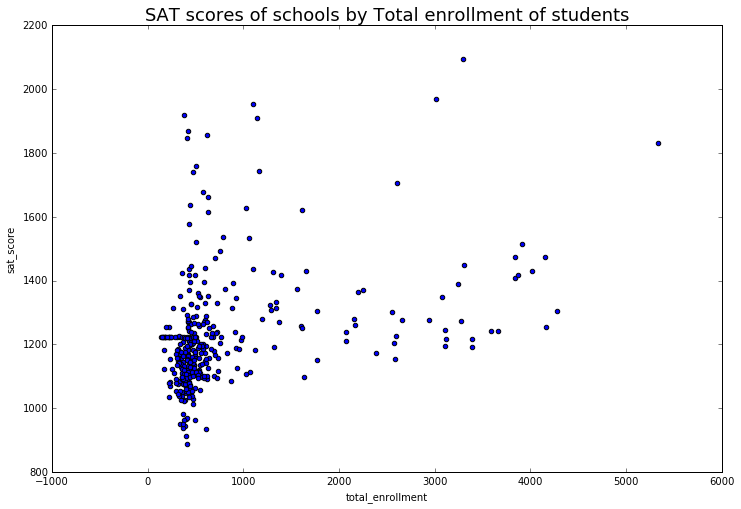

In [45]:
import matplotlib.pyplot as plt

#Scatter plot of total_enrollment vs sat_score
ax = combined.plot(x='total_enrollment', y='sat_score', kind='scatter', figsize=(12,8))
ax.set_title('SAT scores of schools by Total enrollment of students',fontdict={'fontsize':18})
plt.show()

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between sat_score and total_enrollment. If there was a very strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [24]:
#Extracting the names of schools where the total_enrollment ans sat_score is low

low_enrollment = combined[(combined['total_enrollment']<1000) & (combined['sat_score']<1000)]

print(low_enrollment['SCHOOL NAME'])

91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
125                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                     BRONX INTERNATIONAL HIGH SCHOOL
139               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                       HIGH SCHOOL OF WORLD CULTURES
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
225       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                          IT TAKES A VILLAGE ACADEMY
253                           MULTICULTURAL HIGH SCHOOL
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Having done some research on the School names above, it appears that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. To explore this relationship further, let's plot out ell_percent vs sat_score

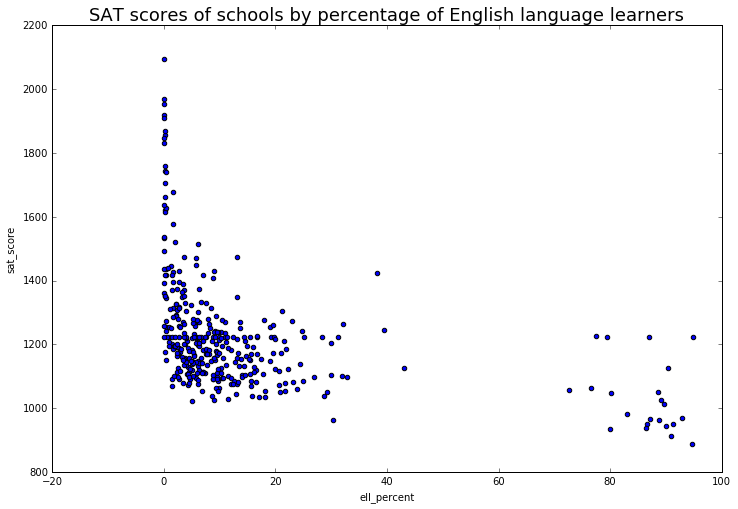

In [46]:
#Scatter plot of ell_percent vs sat_score

ax = combined.plot.scatter(x='ell_percent', y='sat_score', figsize=(12,8))
ax.set_title('SAT scores of schools by percentage of English language learners',fontdict={'fontsize':18})
plt.show()

It looks like ell_percent correlates with sat_score more strongly, because the scatterplot is more linear. However, there's still the cluster of schools that have very high ell_percent values and low sat_score values. This cluster represents the same group of international high schools we investigated earlier.

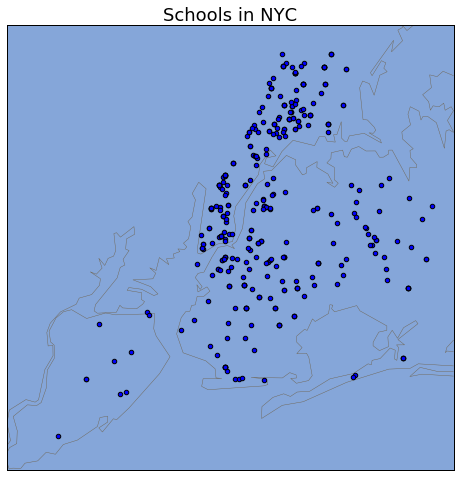

In [47]:
#Mapping the schools locations with basemap

plt.figure(figsize=(8,8))
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

x,y = m(longitudes,latitudes)
m.scatter(x=longitudes, y=latitudes, s=20, zorder=2, latlon=True)
plt.title('Schools in NYC', fontdict={'fontsize':18})
plt.show()

From the map above, we can see that school density is highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island.

Now that we've plotted the school locations, we can begin to display meaningful information on the maps, such as the percentage of English language learners by area.

Note:In all maps plotted below, we'll use the summer colormap, which results in green points for low numbers, and yellow points for high numbers

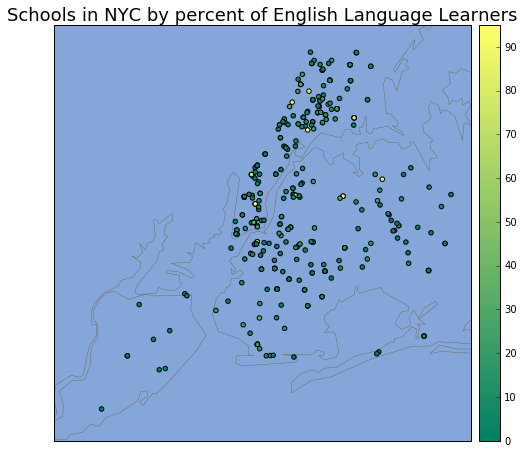

In [48]:
#Mapping out the ell_percent by school locations

plt.figure(figsize=(8,8))
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

x,y = m(longitudes,latitudes)
m.scatter(x=longitudes, y=latitudes, s=20, zorder=2, latlon=True, c=combined['ell_percent'], cmap='summer')
m.colorbar()
plt.title('Schools in NYC by percent of English Language Learners', fontdict={'fontsize':18})
plt.show()

Unfortunately, due to the number of schools, it's hard to interpret the map we made on the last screen. It looks like uptown Manhattan and parts of Queens have a higher ell_percent, but we can't be sure. To make this map easier to read is to aggregate the data shown on the map. In this case, we can aggregate by district, which will enable us to plot ell_percent district-by-district instead of school-by-school.

In [28]:
#Grouping by districts and calculating the mean across all columns
import numpy

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


Now that we've taken the means of all of the columns, we can plot out ell_percent by district. Not only did we find the mean of ell_percent, but we also took the means of the lon and lat columns, which will give us the coordinates for the center of each district.

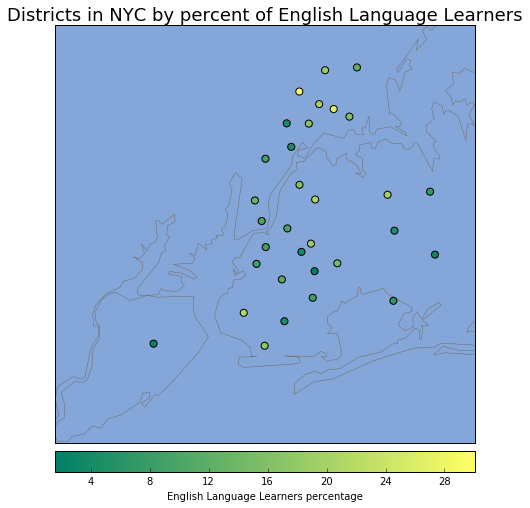

In [49]:
#Mapping out english language learners by districts

from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(8,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

x,y = m(longitudes,latitudes)
m.scatter(x=longitudes, y=latitudes, s=50, zorder=2, latlon=True,  c=districts['ell_percent'], cmap='summer')
m.colorbar(location='bottom', label='English Language Learners percentage')

plt.title('Districts in NYC by percent of English Language Learners', fontdict={'fontsize':18})
plt.show()

# Plotting survey correlations
There are several fields in combined that originally came from a survey of parents, teachers, and students. We make a bar plot of the correlations between these fields and sat_score

In [30]:
# The columns of survey fields had been stored in survey_fields earlier
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.

survey_fields.remove("DBN")

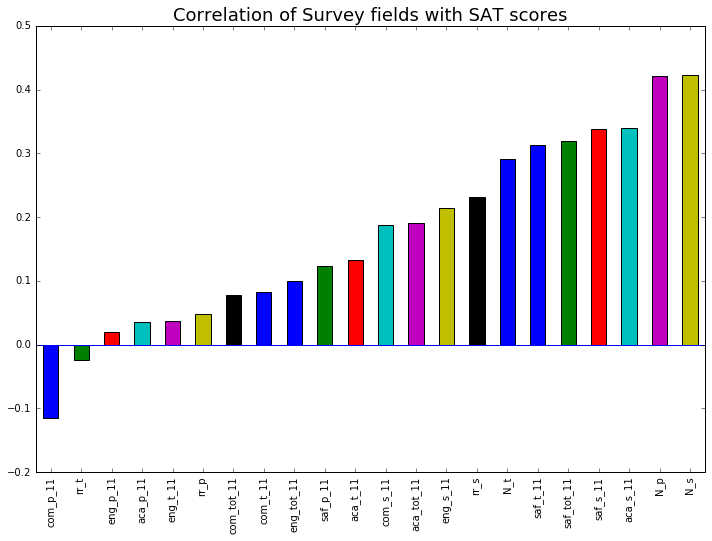

In [50]:
%matplotlib inline

ax = combined.corr()['sat_score'][survey_fields].sort_values().plot.bar(figsize=(12,8))
ax.set_title('Correlation of Survey fields with SAT scores', fontdict={'fontsize':18})

ax.axhline()

From the above plot, there are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring safety
In the last cell, we noticed that saf_t_11 and saf_s_11, which measure how teachers and students respectively perceive safety at school, correlated highly with sat_score. Here, we'll dig into this relationship a bit more, and try to figure out which schools have low safety scores.

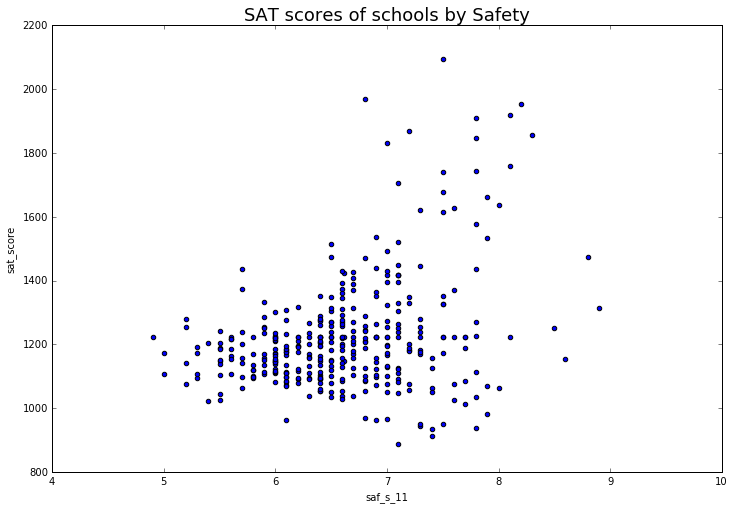

In [32]:
ax = combined.plot(kind='scatter', x='saf_s_11', y='sat_score', figsize=(12,8))
ax.set_title('SAT scores of schools by Safety',fontdict={'fontsize':18} )
plt.show()

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

# Plotting Safety

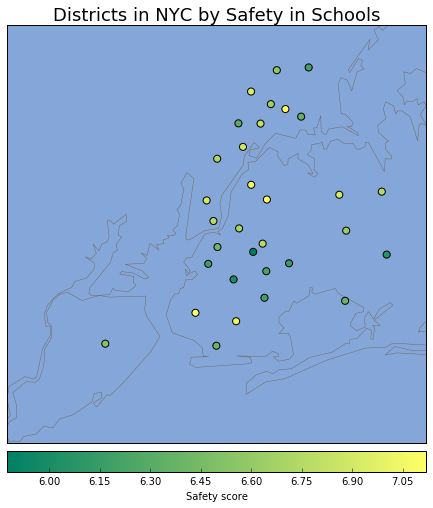

In [33]:
#Mapping out safety by districts

plt.figure(figsize=(8,8))
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(8,8))
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

#m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
m.colorbar(location='bottom', label='Safety score')

plt.title('Districts in NYC by Safety in Schools', fontdict={'fontsize':18})
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

# Racial differences in SAT scores
There are a few columns that indicate the percentage of each race at a given school. We plot the correlations between these columns and sat_score to determine whether there are any racial differences in SAT performance.

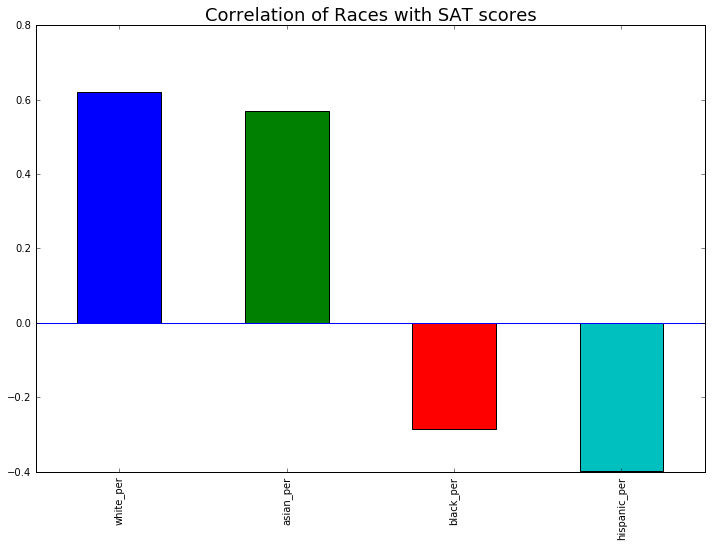

In [51]:
ax = combined.corr()['sat_score'][
    ['white_per','asian_per','black_per','hispanic_per']
].plot.bar(figsize=(12,8))
ax.set_title('Correlation of Races with SAT scores', fontdict={'fontsize':18})

ax.axhline()
plt.show()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

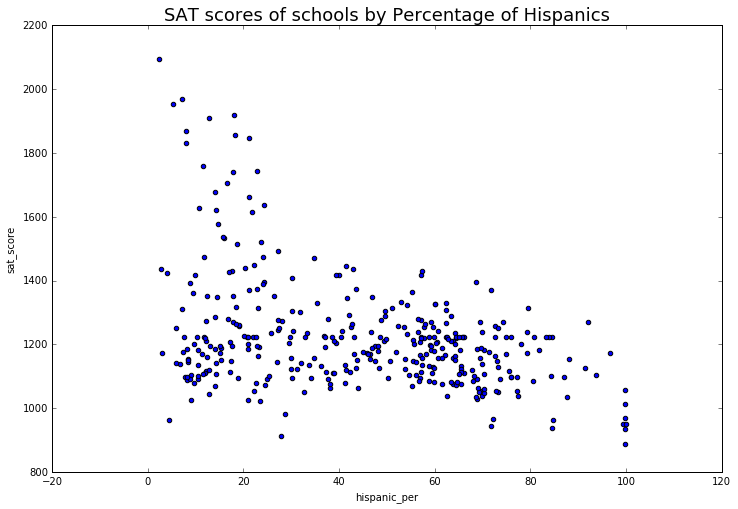

In [35]:
ax = combined.plot.scatter(x='hispanic_per', y='sat_score', figsize=(12,8))
ax.set_title('SAT scores of schools by Percentage of Hispanics',fontdict={'fontsize':18} )

In [36]:
print(combined[combined['hispanic_per']>95]['SCHOOL NAME'])


44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Having done research on the school names above, the schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores

In [37]:
print(combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]['SCHOOL NAME'])


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools listed above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Gender differences in SAT scores

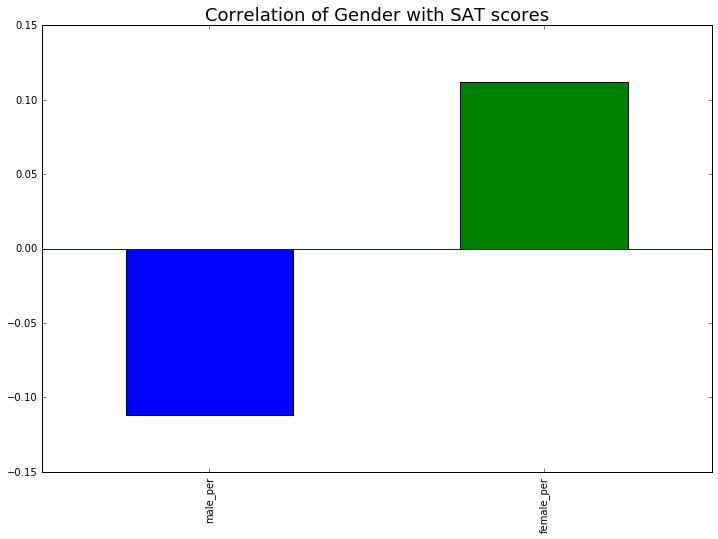

In [52]:
ax = combined.corr()['sat_score'][
    ['male_per','female_per']
].plot.bar(figsize=(12,8))
ax.set_title('Correlation of Gender with SAT scores', fontdict={'fontsize':18})

ax.axhline()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

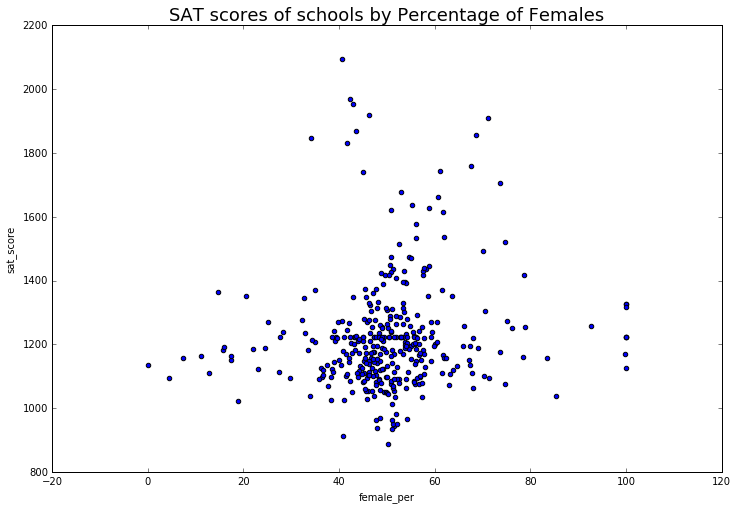

In [39]:
ax = combined.plot.scatter(x='female_per',y='sat_score', figsize=(12,8))
ax.set_title('SAT scores of schools by Percentage of Females',fontdict={'fontsize':18})

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [40]:
print(combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

# AP Exam Scores vs SAT Scores

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam

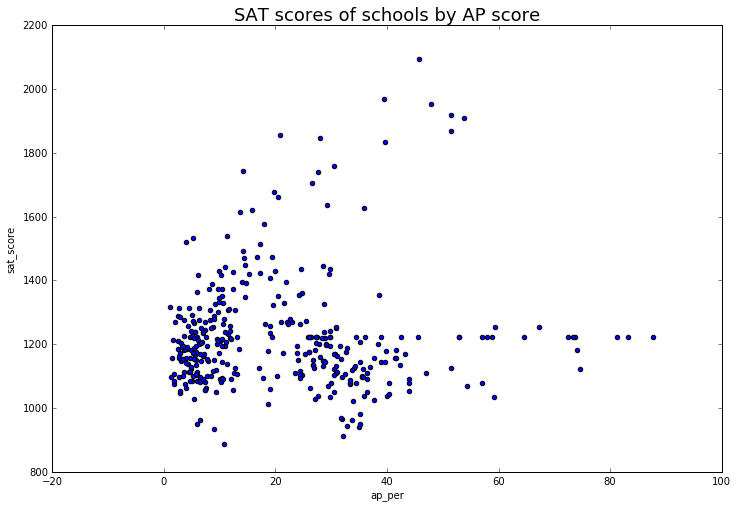

In [41]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] * 100

ax = combined.plot.scatter('ap_per', 'sat_score', figsize=(12,8))

ax.set_title('SAT scores of schools by AP score',fontdict={'fontsize':18} )
plt.show()

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Exploring Class size and SAT Scores

In [42]:
combined.corr()['sat_score'][['AVERAGE CLASS SIZE',
                             'NUMBER OF STUDENTS / SEATS FILLED']]

AVERAGE CLASS SIZE                   0.381014
NUMBER OF STUDENTS / SEATS FILLED    0.394626
Name: sat_score, dtype: float64

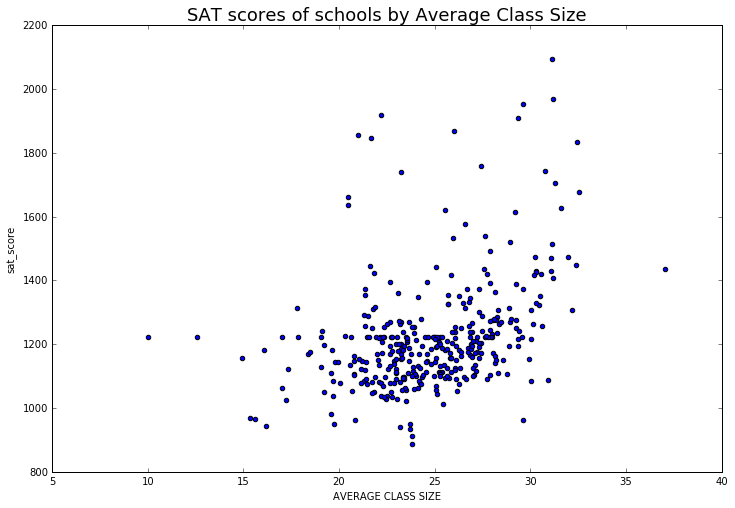

In [43]:
ax = combined.plot.scatter('AVERAGE CLASS SIZE','sat_score', figsize=(12,8))

ax.set_title('SAT scores of schools by Average Class Size',fontdict={'fontsize':18} )
plt.show()

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and average class size.

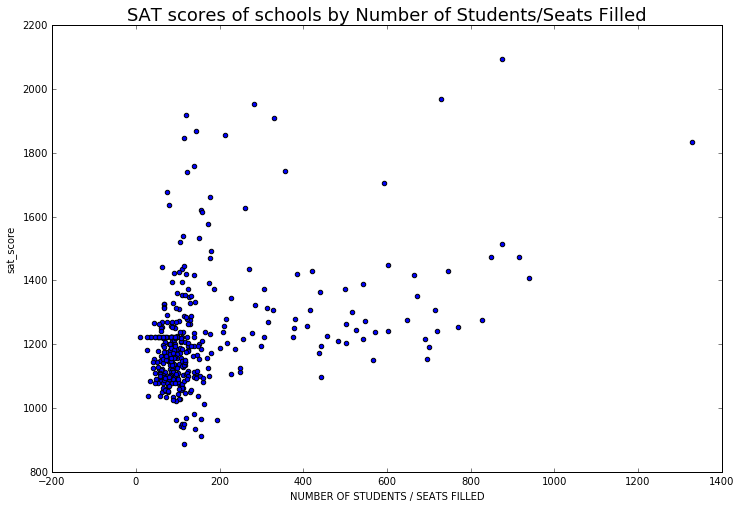

In [44]:
ax = combined.plot.scatter('NUMBER OF STUDENTS / SEATS FILLED','sat_score', figsize=(12,8))

ax.set_title('SAT scores of schools by Number of Students/Seats Filled',fontdict={'fontsize':18} )
plt.show()

There is definetly a point to be made for larger classes. This is made more evident by the NUMBER OF STUDENTS/ SEATS FILLED column. Schools with higher population have a higher tendency of having higher SAT scores

# CONCLUSION

   * Schools with higher average SAT scores seem to have a higher Safety and Respect score based on Student responses in the surveys.
   * SAT is not favourable to black/hispanic students, as schools with higher percentage of these students have lower SAT scores.
   
